<a href="https://colab.research.google.com/github/EBUSYGIN/ML-3/blob/Kuznetsov/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import PolynomialFeatures

In [14]:
# Загрузка данных
train_path = "train.xlsx"
test_path = "test.xlsx"
train_df = pd.read_excel(train_path)
test_df = pd.read_excel(test_path)


In [15]:
# Преобразование даты в индекс
train_df["dt"] = pd.to_datetime(train_df["dt"])
test_df["dt"] = pd.to_datetime(test_df["dt"])
train_df.set_index("dt", inplace=True)
test_df.set_index("dt", inplace=True)

In [16]:
# Проверка стационарности
adf_test = adfuller(train_df["Цена на арматуру"])
print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}")

ADF Statistic: -1.9258699893713456, p-value: 0.31999061025699155


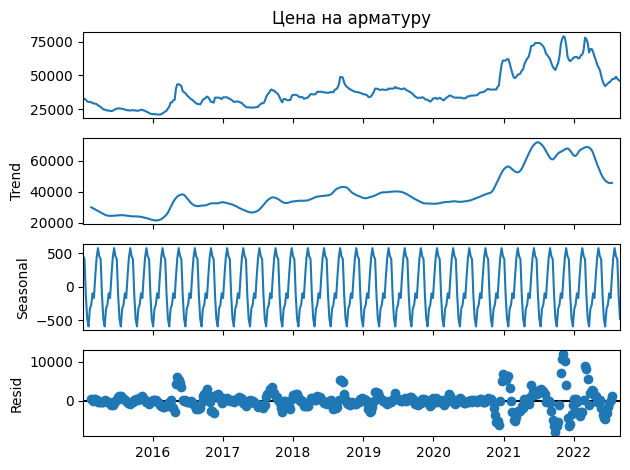

In [17]:
# Разложение временного ряда
decomposition = seasonal_decompose(train_df["Цена на арматуру"], model='additive', period=12)
decomposition.plot()
plt.show()

In [18]:

# Добавление новых признаков
train_df['year'] = train_df.index.year
train_df['month'] = train_df.index.month
test_df['year'] = test_df.index.year
test_df['month'] = test_df.index.month


In [19]:
# Скользящее среднее
train_df['rolling_mean_3'] = train_df['Цена на арматуру'].rolling(window=3).mean().fillna(method='bfill')
test_df['rolling_mean_3'] = test_df['Цена на арматуру'].rolling(window=3).mean().fillna(method='bfill')

# Лаги (задержки)
train_df['lag_1'] = train_df['Цена на арматуру'].shift(1).fillna(method='bfill')
test_df['lag_1'] = test_df['Цена на арматуру'].shift(1).fillna(method='bfill')

# Преобразование даты в числовой формат
train_df["timestamp"] = train_df.index.astype(np.int64) // 10**9
test_df["timestamp"] = test_df.index.astype(np.int64) // 10**9

<ipython-input-19-20168b1ee927>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df['rolling_mean_3'] = train_df['Цена на арматуру'].rolling(window=3).mean().fillna(method='bfill')
<ipython-input-19-20168b1ee927>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df['rolling_mean_3'] = test_df['Цена на арматуру'].rolling(window=3).mean().fillna(method='bfill')
<ipython-input-19-20168b1ee927>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df['lag_1'] = train_df['Цена на арматуру'].shift(1).fillna(method='bfill')
<ipython-input-19-20168b1ee927>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df['lag_1'] = test_df['Ц

In [20]:
# Создание полиномиальных признаков
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(train_df[["timestamp", "year", "month", "rolling_mean_3", "lag_1"]])
X_test_poly = poly.transform(test_df[["timestamp", "year", "month", "rolling_mean_3", "lag_1"]])

# Разделение на признаки и целевую переменную
y_train = train_df["Цена на арматуру"]
y_test = test_df["Цена на арматуру"]


In [21]:

# Обучение модели
model = LinearRegression()
model.fit(X_train_poly, y_train)


LinearRegression()

In [22]:
# Прогнозирование
predictions = model.predict(X_test_poly)

MAE: 895.7040900504154, MSE: 1799453.9923757426, RMSE: 1341.4372860390242, MAPE: 1.910931263539125, SMAPE: 1.9456742081708722


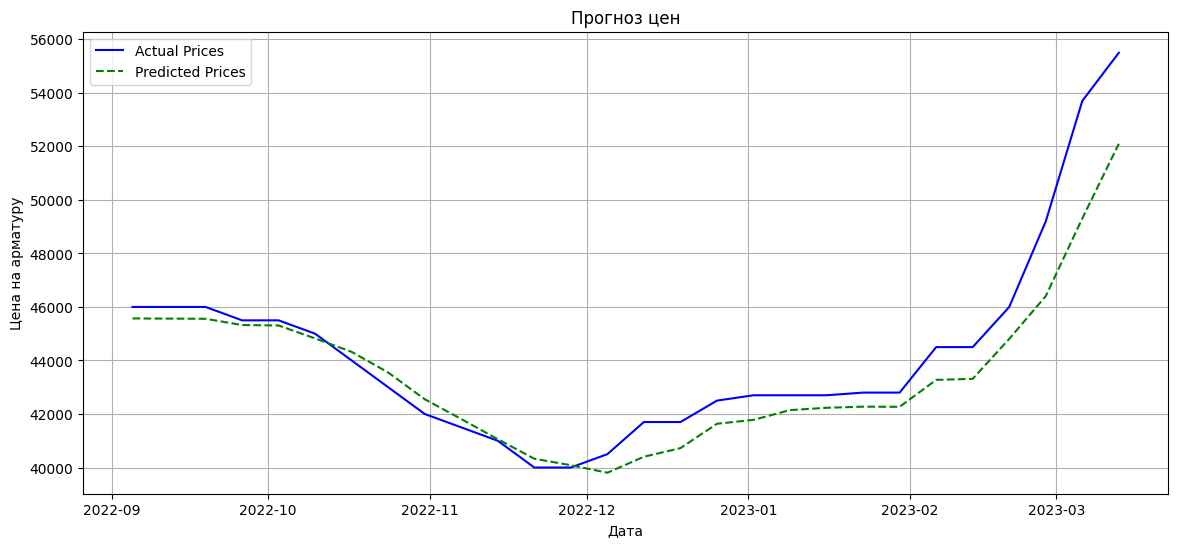

In [23]:
# Оценка модели
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
smape = 100 * np.mean(2 * np.abs(predictions - y_test) / (np.abs(predictions) + np.abs(y_test)))

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}, SMAPE: {smape}")

# Визуализация прогнозов
plt.figure(figsize=(14, 6))
plt.plot(test_df.index, y_test, label="Actual Prices", color='blue')
plt.plot(test_df.index, predictions, label="Predicted Prices", color='green', linestyle='dashed')
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Прогноз цен")
plt.legend()
plt.grid()
plt.show()